References

1. https://cs231n.github.io/neural-networks-2/#reg
2. https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/DL2/Bayesian_Neural_Networks/dl2_bnn_tut2_student_with_answers.html

## Imports

In [1]:
### Regular Dropout

import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd

import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Use GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [2]:
from tueplots import bundles
plt.rcParams.update(bundles.beamer_moml())


# Also add despine to the bundle using rcParams
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

# Increase font size to match Beamer template
plt.rcParams['font.size'] = 16
# Make background transparent
plt.rcParams['figure.facecolor'] = 'none'

Inspired from: https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/DL2/Bayesian_Neural_Networks/dl2_bnn_tut2_student_with_answers.html

In [3]:
def get_simple_data_train():
    x = torch.linspace(-2, 4, 300)
    x = torch.hstack([x, torch.linspace(6, 8, 300)])
    f = lambda x: torch.sin(x)
    eps = torch.randn_like(x) * 0.1
    f_x = f(x) 
    y_train = f_x + eps
    x_train = x[:, None]
    return x_train, y_train, f

In [4]:
def plot_generic(add_to_plot=None):
    fig, ax = plt.subplots()

    plt.xlabel("X",)
    plt.ylabel("Y",)

    x_train, y_train, true_func = get_simple_data_train()
    
    x_all = torch.linspace(-2, 8, 1000)

    ax.plot(x_train, y_train, 'C0', marker='o', ms= 4, linestyle='none', alpha=0.2, label='Observations')
    ax.plot(x_all, true_func(x_all), 'C1', linewidth=1, label="true function")
    if add_to_plot is not None:
        add_to_plot(ax)

    plt.legend(loc=4, frameon=False)
    plt.show()

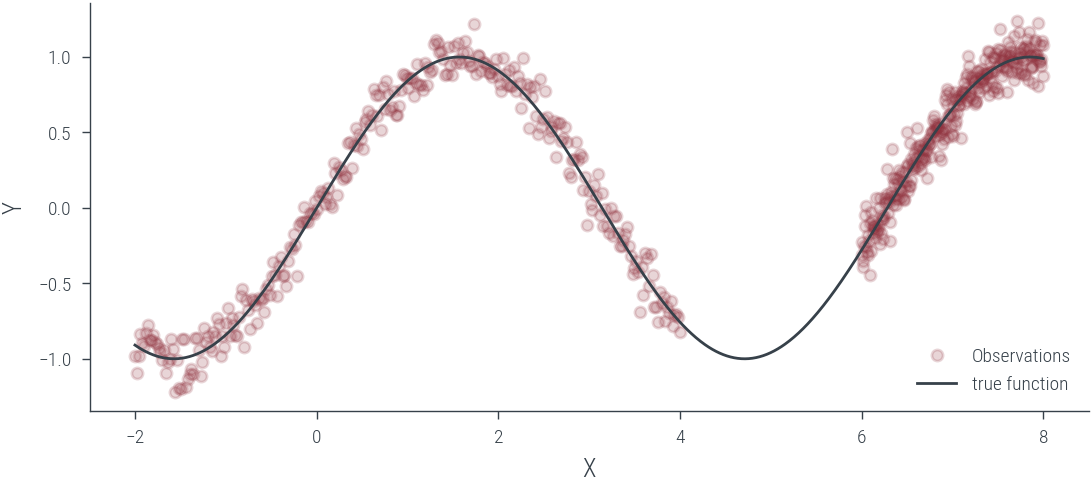

In [5]:
plot_generic()

In [6]:
# Define a simple MLP without using nn.Linear

input_dim = 1

hidden_l1_dim = 100
hidden_l2_dim = 50


def init_params():
    W1 = nn.Parameter(torch.randn(input_dim, hidden_l1_dim, requires_grad=True).to(device))
    b1 = nn.Parameter(torch.zeros(hidden_l1_dim, requires_grad=True).to(device))
    W2 = nn.Parameter(torch.randn(hidden_l1_dim, hidden_l2_dim, requires_grad=True).to(device))
    b2 = nn.Parameter(torch.zeros(hidden_l2_dim, requires_grad=True).to(device))
    W3 = nn.Parameter(torch.randn(hidden_l2_dim, 1, requires_grad=True).to(device))
    b3 = nn.Parameter(torch.zeros(1, requires_grad=True).to(device))
    return [W1, b1, W2, b2, W3, b3]


def mlp(x, params, p=0.0):
    W1, b1, W2, b2, W3, b3 = params
    h1 = torch.tanh(x @ W1 + b1)
    h2 = torch.tanh(h1 @ W2 + b2)
    return (h2 @ W3 + b3).ravel()

In [7]:
train_x, train_y, true_func = get_simple_data_train()
train_x = train_x.to(device)
train_y = train_y.to(device)


In [8]:
train_x.shape

torch.Size([600, 1])

In [9]:
test_x = torch.linspace(-2, 8, 1000)[:, None]
test_x = test_x.to(device)

In [10]:
parameters = init_params()


with torch.no_grad():
    y_hat_untrained = mlp(test_x, parameters).ravel()
# Detach and convert to numpy
y_hat_untrained = y_hat_untrained.cpu().detach().numpy()

In [11]:
def plot_predictions(x_test, y_preds):
    def add_predictions(ax):
        ax.plot(x_test, y_preds, 'C2', label='neural net prediction')

    plot_generic(add_predictions)


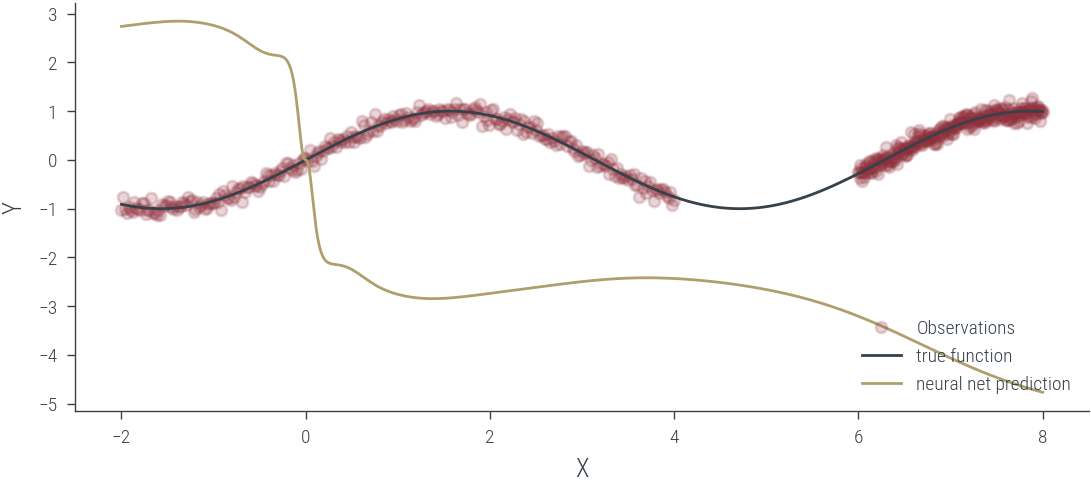

In [12]:
# Plot the untrained model
plot_predictions(test_x.cpu(), y_hat_untrained)

## Simple MLP

In [13]:
# Modify the train function to pass the dropout flag and dropout probability
def train(params, opt, fwd_func, x_train, y_train, epochs=1000, dropout=False, p=0.0):
    for i in range(epochs):
        y_hat = fwd_func(x_train, params, p)  # Pass the dropout flag and probability to fwd_func
        loss = F.mse_loss(y_hat, y_train)
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        if i % 300 == 0:
            print(f"Epoch {i}, loss {loss.item():.3f}")
    return params

In [14]:
parameters = init_params()

# Continue with optimizer
optimizer = torch.optim.Adam(parameters, lr=3e-4)

trained_params = train(parameters, optimizer, mlp, train_x, train_y, epochs=6000, dropout=False, p=0.0)

Epoch 0, loss 6.558
Epoch 300, loss 0.021
Epoch 600, loss 0.016
Epoch 900, loss 0.014
Epoch 1200, loss 0.014
Epoch 1500, loss 0.013
Epoch 1800, loss 0.013
Epoch 2100, loss 0.013
Epoch 2400, loss 0.013
Epoch 2700, loss 0.012
Epoch 3000, loss 0.011
Epoch 3300, loss 0.011
Epoch 3600, loss 0.010
Epoch 3900, loss 0.010
Epoch 4200, loss 0.010
Epoch 4500, loss 0.010
Epoch 4800, loss 0.010
Epoch 5100, loss 0.010
Epoch 5400, loss 0.010
Epoch 5700, loss 0.010


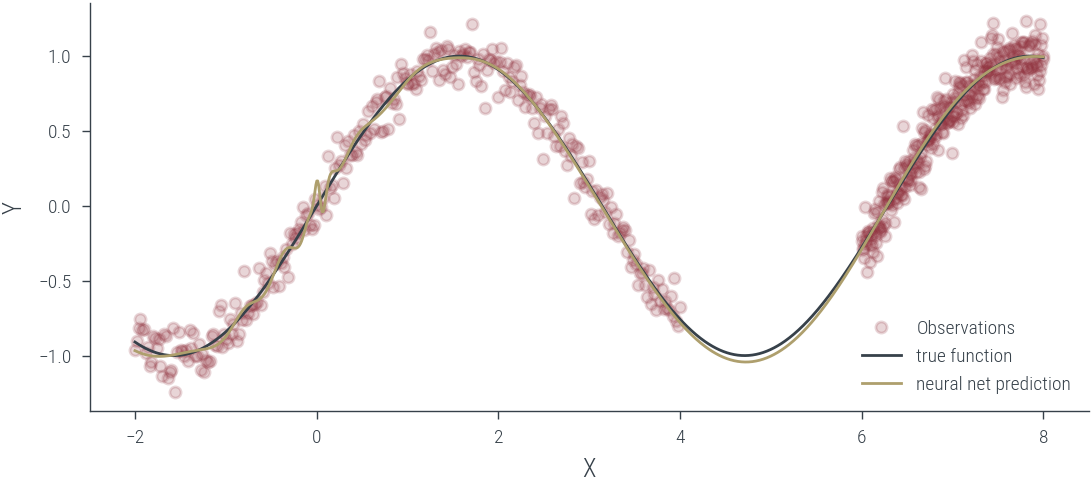

In [15]:
# Plot the trained model
with torch.no_grad():
    y_hat_trained = mlp(test_x, trained_params).ravel()
# Detach and convert to numpy
y_hat_trained = y_hat_trained.cpu().detach().numpy()

plot_predictions(test_x.cpu(), y_hat_trained)

## Deep ensemble

In [16]:
# Define a simple MLP without using nn.Linear

input_dim = 1

hidden_l1_dim = 100
hidden_l2_dim = 50


def init_params():
    W1 = nn.Parameter(torch.randn(input_dim, hidden_l1_dim, requires_grad=True).to(device))
    b1 = nn.Parameter(torch.zeros(hidden_l1_dim, requires_grad=True).to(device))
    W2 = nn.Parameter(torch.randn(hidden_l1_dim, hidden_l2_dim, requires_grad=True).to(device))
    b2 = nn.Parameter(torch.zeros(hidden_l2_dim, requires_grad=True).to(device))
    W3 = nn.Parameter(torch.randn(hidden_l2_dim, 1, requires_grad=True).to(device))
    b3 = nn.Parameter(torch.zeros(1, requires_grad=True).to(device))
    return [W1, b1, W2, b2, W3, b3]


def mlp(x, params, p=0.0):
    W1, b1, W2, b2, W3, b3 = params
    h1 = torch.tanh(x @ W1 + b1)
    h2 = torch.tanh(h1 @ W2 + b2)
    return (h2 @ W3 + b3).ravel()

In [17]:
n_ensembles = 5

ensemble_params_list = []
for i in range(n_ensembles):
    print(f"Training ensemble member {i}")
    parameters = init_params()
    optimizer = torch.optim.Adam(parameters, lr=3e-4)
    trained_params = train(parameters, optimizer, mlp, train_x, train_y, epochs=6000, dropout=False, p=0.0)
    ensemble_params_list.append(trained_params)

Training ensemble member 0
Epoch 0, loss 15.912
Epoch 300, loss 0.049


Epoch 600, loss 0.021
Epoch 900, loss 0.016
Epoch 1200, loss 0.015
Epoch 1500, loss 0.014
Epoch 1800, loss 0.014
Epoch 2100, loss 0.014
Epoch 2400, loss 0.013
Epoch 2700, loss 0.013
Epoch 3000, loss 0.013
Epoch 3300, loss 0.012
Epoch 3600, loss 0.012
Epoch 3900, loss 0.012
Epoch 4200, loss 0.011
Epoch 4500, loss 0.011
Epoch 4800, loss 0.010
Epoch 5100, loss 0.010
Epoch 5400, loss 0.010
Epoch 5700, loss 0.010
Training ensemble member 1
Epoch 0, loss 86.726
Epoch 300, loss 0.277
Epoch 600, loss 0.096
Epoch 900, loss 0.047
Epoch 1200, loss 0.026
Epoch 1500, loss 0.019
Epoch 1800, loss 0.016
Epoch 2100, loss 0.015
Epoch 2400, loss 0.014
Epoch 2700, loss 0.013
Epoch 3000, loss 0.013
Epoch 3300, loss 0.012
Epoch 3600, loss 0.012
Epoch 3900, loss 0.012
Epoch 4200, loss 0.012
Epoch 4500, loss 0.011
Epoch 4800, loss 0.011
Epoch 5100, loss 0.011
Epoch 5400, loss 0.011
Epoch 5700, loss 0.011
Training ensemble member 2
Epoch 0, loss 101.818
Epoch 300, loss 0.191
Epoch 600, loss 0.049
Epoch 900, lo

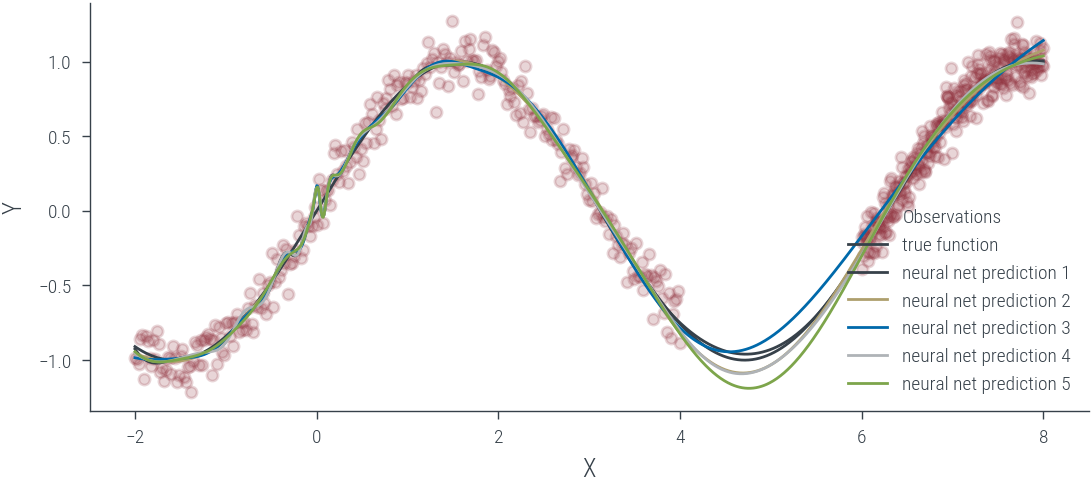

In [18]:
# Plot the trained model
def plot_deep_ensemble(x_test, y_preds_list):
    def add_predictions(ax):
        for i, y_preds in enumerate(y_preds_list, 1):
            ax.plot(x_test, y_preds, f'C{i}', label=f'neural net prediction {i}')

    plot_generic(add_predictions)

y_preds_list = []
for trained_params in ensemble_params_list:
    with torch.no_grad():
        y_hat_trained = mlp(test_x, trained_params)
        y_hat_trained = y_hat_trained.cpu().numpy()
        y_preds_list.append(y_hat_trained)
        
plot_deep_ensemble(test_x.cpu(), y_preds_list)

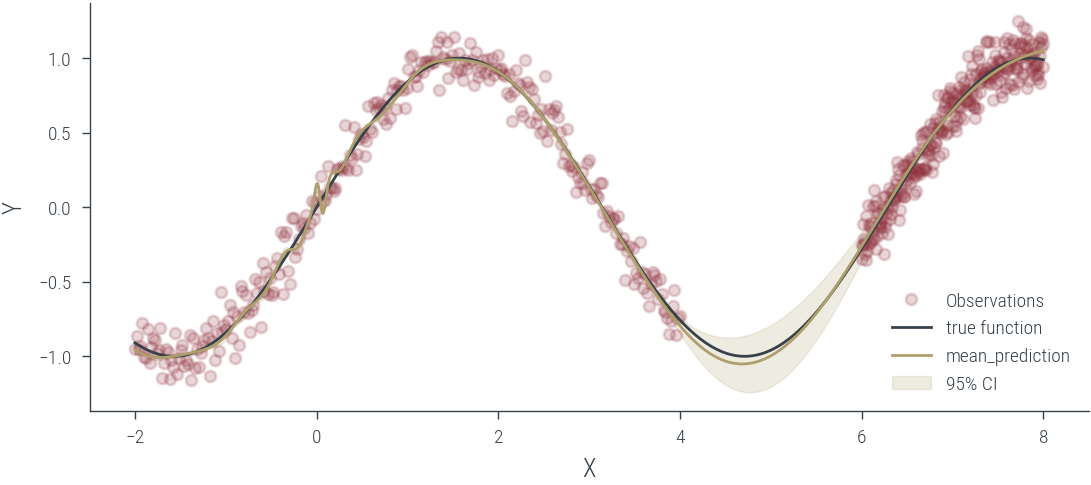

In [19]:
def plot_deep_ensemble_uncertainty(x_test, y_preds_list):
    def add_predictions(ax):
        y_mean = np.array(y_preds_list).mean(axis=0)
        y_std = np.array(y_preds_list).std(axis=0)
        ax.plot(x_test, y_mean, f'C2', label=f'mean_prediction')
        ax.fill_between(x_test.ravel(), y_mean - 2*y_std, y_mean + 2*y_std, alpha=0.2, color='C2', label='95% CI')

    plot_generic(add_predictions)
    
plot_deep_ensemble_uncertainty(test_x.cpu(), y_preds_list)

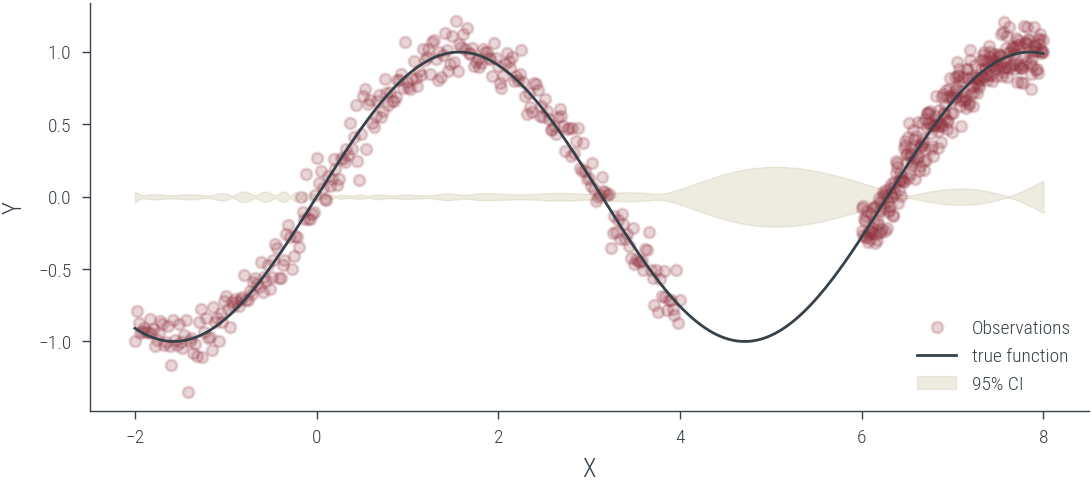

In [20]:
def plot_just_uncertainty_deep_ensemble(x_test, y_preds_list):
    def add_predictions(ax):
        y_std = np.array(y_preds_list).std(axis=0)
        ax.fill_between(x_test.ravel(), -2*y_std, 2*y_std, alpha=0.2, color='C2', label='95% CI')

    plot_generic(add_predictions)
    
plot_just_uncertainty_deep_ensemble(test_x.cpu(), y_preds_list)

## Dropout from scratch

In [21]:
### Now adding dropout to the model by manually masking the activations
W1, b1, W2, b2, W3, b3 = parameters
h1 = torch.relu(test_x @ W1 + b1)
h1.shape


torch.Size([1000, 100])

In [22]:
# probability of dropping out each neuron
p = 0.2

In [23]:
mask = torch.rand_like(h1) > p
mask.shape

torch.Size([1000, 100])

In [24]:
h1.shape

torch.Size([1000, 100])

In [25]:
mask.sum()

tensor(80101, device='cuda:0')

In [26]:
mask.numel()

100000

In [27]:
masked_activations = h1 * mask
masked_activations.shape

torch.Size([1000, 100])

In [28]:
pd.DataFrame(masked_activations.cpu().detach().numpy()).head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.916828,1.098538,0.0,0.000000,0.0,1.827338,0.083864,1.197483,0.0,0.0,...,0.0,0.0,0.174088,0.080000,0.0,0.0,0.0,0.0,1.126390,0.0
1,0.912075,0.000000,0.0,2.326014,0.0,1.818093,0.000000,1.191452,0.0,0.0,...,0.0,0.0,0.173284,0.000000,0.0,0.0,0.0,0.0,1.120717,0.0
2,0.907321,1.087827,0.0,2.314110,0.0,1.808849,0.082876,1.185422,0.0,0.0,...,0.0,0.0,0.172481,0.079278,0.0,0.0,0.0,0.0,1.115044,0.0
3,0.902567,1.082472,0.0,0.000000,0.0,1.799604,0.082383,1.179391,0.0,0.0,...,0.0,0.0,0.171677,0.078917,0.0,0.0,0.0,0.0,1.109372,0.0
4,0.000000,1.077117,0.0,2.290304,0.0,1.790359,0.000000,1.173361,0.0,0.0,...,0.0,0.0,0.170874,0.000000,0.0,0.0,0.0,0.0,1.103699,0.0


In [29]:
pd.DataFrame(h1.cpu().detach().numpy()).head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.916828,1.098538,0.0,2.337917,0.0,1.827338,0.083864,1.197483,0.0,0.0,...,0.0,0.0,0.174088,0.080000,0.0,0.0,0.0,0.0,1.126390,0.0
1,0.912075,1.093183,0.0,2.326014,0.0,1.818093,0.083370,1.191452,0.0,0.0,...,0.0,0.0,0.173284,0.079639,0.0,0.0,0.0,0.0,1.120717,0.0
2,0.907321,1.087827,0.0,2.314110,0.0,1.808849,0.082876,1.185422,0.0,0.0,...,0.0,0.0,0.172481,0.079278,0.0,0.0,0.0,0.0,1.115044,0.0
3,0.902567,1.082472,0.0,2.302207,0.0,1.799604,0.082383,1.179391,0.0,0.0,...,0.0,0.0,0.171677,0.078917,0.0,0.0,0.0,0.0,1.109372,0.0
4,0.897814,1.077117,0.0,2.290304,0.0,1.790359,0.081889,1.173361,0.0,0.0,...,0.0,0.0,0.170874,0.078556,0.0,0.0,0.0,0.0,1.103699,0.0


In [30]:
pd.DataFrame(mask.cpu().detach().numpy()).head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,True,True,True,False,False,True,True,True,True,True,...,True,True,True,True,False,True,True,True,True,True
1,True,False,True,True,True,True,False,True,True,True,...,True,True,True,False,True,True,False,True,True,True
2,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
3,True,True,True,False,False,True,True,True,False,True,...,False,True,True,True,True,False,True,True,True,True
4,False,True,True,True,True,True,False,True,True,True,...,True,True,True,False,True,False,True,True,True,True


## MC-dropout

In [31]:
### Rewriting the model with dropout

def mlp_dropout(x, params, p=0.0, training=True):
    W1, b1, W2, b2, W3, b3 = params
    h1 = torch.tanh(x @ W1 + b1)
    #h2 = torch.sin(h1 @ W2 + b2)
    #h3 = h2 @ W3 + b3
    #return h3
    if training:
        # probability of dropping out each neuron
        mask = torch.rand_like(h1) > p
        h1 = h1 * mask
        # scale activations to account for dropout
        #h1 = h1 / (1 - p)
    h2 = torch.tanh(h1 @ W2 + b2)
    if training:
        # probability of dropping out each neuron
        mask = torch.rand_like(h2) > p
        h2 = h2 * mask
        # scale activations to account for dropout
        #h2 = h2 / (1 - p)
    h3 = h2 @ W3 + b3
    return h3.ravel()

In [32]:
# Train the model
p = 0.1
parameters = init_params()

# Continue with optimizer
optimizer = torch.optim.Adam(parameters, lr=3e-4)
trained_params = train(parameters, optimizer, mlp_dropout, train_x, train_y, epochs=10000, dropout=True, p=p)

Epoch 0, loss 27.042


Epoch 300, loss 8.256
Epoch 600, loss 6.136
Epoch 900, loss 5.107
Epoch 1200, loss 4.798
Epoch 1500, loss 4.483
Epoch 1800, loss 4.029
Epoch 2100, loss 3.853
Epoch 2400, loss 3.249
Epoch 2700, loss 3.046
Epoch 3000, loss 2.989
Epoch 3300, loss 2.740
Epoch 3600, loss 2.610
Epoch 3900, loss 2.517
Epoch 4200, loss 1.905
Epoch 4500, loss 1.849
Epoch 4800, loss 1.498
Epoch 5100, loss 1.480
Epoch 5400, loss 1.187
Epoch 5700, loss 1.086
Epoch 6000, loss 1.046
Epoch 6300, loss 0.864
Epoch 6600, loss 0.764
Epoch 6900, loss 0.762
Epoch 7200, loss 0.593
Epoch 7500, loss 0.574
Epoch 7800, loss 0.479
Epoch 8100, loss 0.440
Epoch 8400, loss 0.337
Epoch 8700, loss 0.307
Epoch 9000, loss 0.278
Epoch 9300, loss 0.251
Epoch 9600, loss 0.217
Epoch 9900, loss 0.216


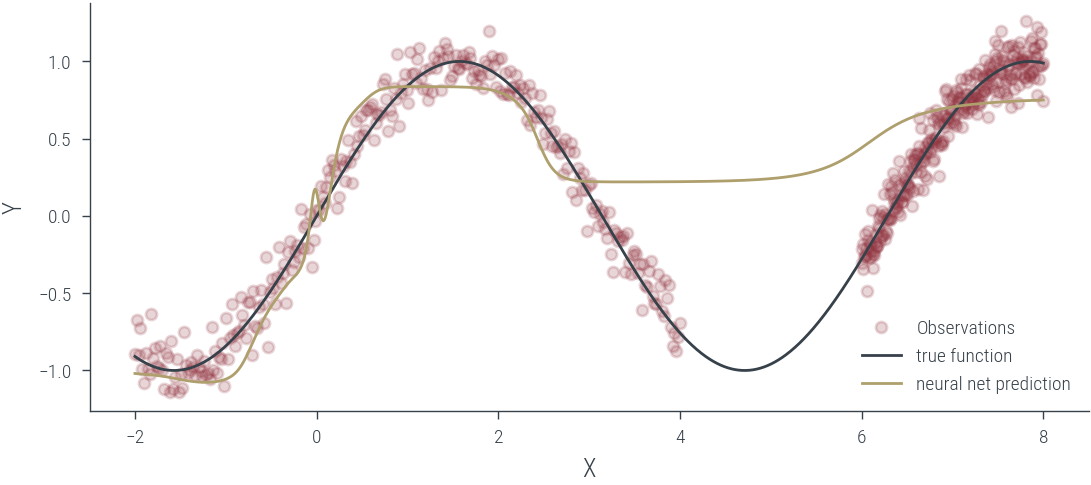

In [33]:
# Predictions with dropout
with torch.no_grad():
    y_hat_dropout = mlp_dropout(test_x, trained_params, training=False).ravel()

# Detach and convert to numpy
y_hat_dropout = y_hat_dropout.cpu().detach().numpy()

plot_predictions(test_x.cpu(), y_hat_dropout)

    

In [34]:
# Get the predictions for the test set with dropout set to True

preds = []
for i in range(100):
    with torch.no_grad():
        y_hat_dropout = mlp_dropout(test_x, trained_params, training=True, p=p).ravel()
    # Detach and convert to numpy
    y_hat_dropout = y_hat_dropout.cpu().detach().numpy()
    preds.append(y_hat_dropout)

In [35]:
# Plot MC dropout predictions

preds = np.array(preds)
preds.shape

(100, 1000)

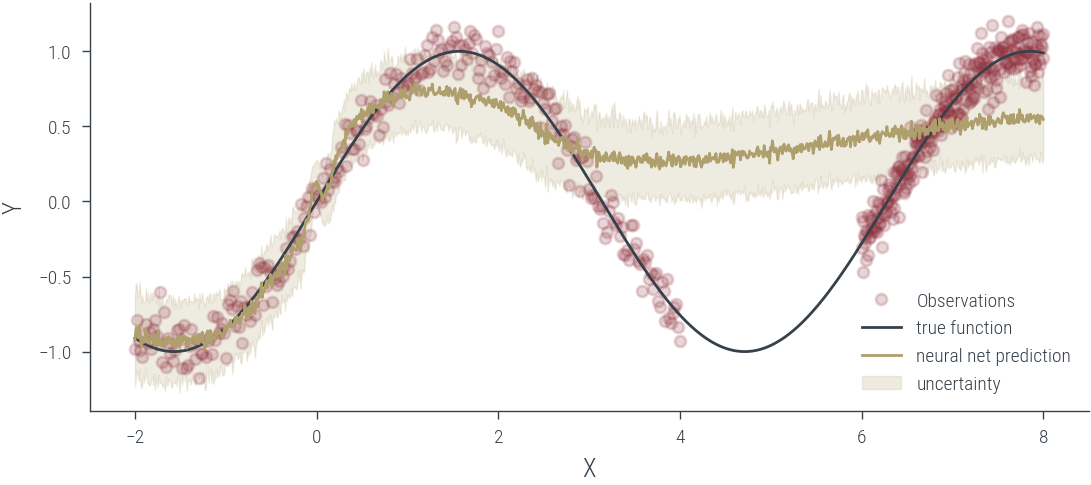

In [36]:
# Plot mean and variance of MC dropout predictions

mean = preds.mean(axis=0)
std = preds.std(axis=0)

def plot_predictions_with_uncertainty(x_test, y_preds, y_std):
    def add_predictions(ax):
        ax.plot(x_test, y_preds, 'C2', label='neural net prediction')
        ax.fill_between(x_test.ravel(), y_preds - y_std, y_preds + y_std, alpha=0.2, color='C2', label='uncertainty')

    plot_generic(add_predictions)

plot_predictions_with_uncertainty(test_x.cpu(), mean, std)


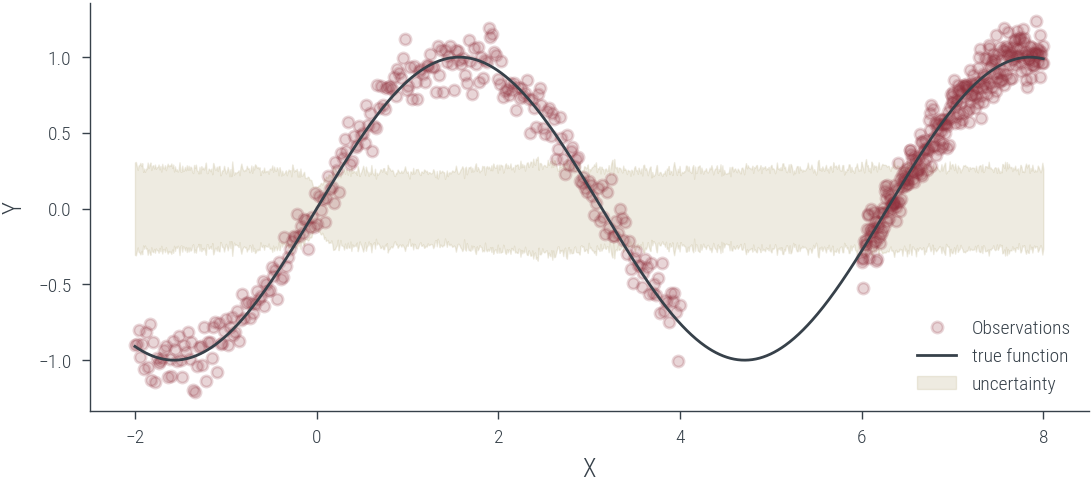

In [37]:
# Just plot the uncertainty

def plot_uncertainty(x_test, y_std):
    def add_predictions(ax):
        ax.fill_between(x_test.ravel(), -y_std, y_std, alpha=0.2, color='C2', label='uncertainty')

    plot_generic(add_predictions)
    
plot_uncertainty(test_x.cpu(), std)

## MLP with residual connections

> We need to have same number of neurons in all layers to form a residual connection.

In [38]:
# Define a simple MLP without using nn.Linear

input_dim = 1

hidden_l1_dim = 50
hidden_l2_dim = 50


def init_params():
    W1 = nn.Parameter(torch.randn(input_dim, hidden_l1_dim, requires_grad=True).to(device))
    b1 = nn.Parameter(torch.zeros(hidden_l1_dim, requires_grad=True).to(device))
    W2 = nn.Parameter(torch.randn(hidden_l1_dim, hidden_l2_dim, requires_grad=True).to(device))
    b2 = nn.Parameter(torch.zeros(hidden_l2_dim, requires_grad=True).to(device))
    W3 = nn.Parameter(torch.randn(hidden_l2_dim, 1, requires_grad=True).to(device))
    b3 = nn.Parameter(torch.zeros(1, requires_grad=True).to(device))
    return [W1, b1, W2, b2, W3, b3]


def mlp(x, params, p=0.0):
    W1, b1, W2, b2, W3, b3 = params
    h1 = torch.tanh(x @ W1 + b1)
    h2 = torch.tanh(h1 @ W2 + b2)
    # residual connection
    h2 = h2 + h1
    return (h2 @ W3 + b3).ravel()

In [39]:
parameters = init_params()

# Continue with optimizer
optimizer = torch.optim.Adam(parameters, lr=3e-4)

trained_params = train(parameters, optimizer, mlp, train_x, train_y, epochs=6000, dropout=False, p=0.0)

Epoch 0, loss 21.025
Epoch 300, loss 0.135


Epoch 600, loss 0.052
Epoch 900, loss 0.021
Epoch 1200, loss 0.016
Epoch 1500, loss 0.014
Epoch 1800, loss 0.013
Epoch 2100, loss 0.013
Epoch 2400, loss 0.012
Epoch 2700, loss 0.012
Epoch 3000, loss 0.012
Epoch 3300, loss 0.012
Epoch 3600, loss 0.011
Epoch 3900, loss 0.011
Epoch 4200, loss 0.011
Epoch 4500, loss 0.011
Epoch 4800, loss 0.011
Epoch 5100, loss 0.011
Epoch 5400, loss 0.010
Epoch 5700, loss 0.010


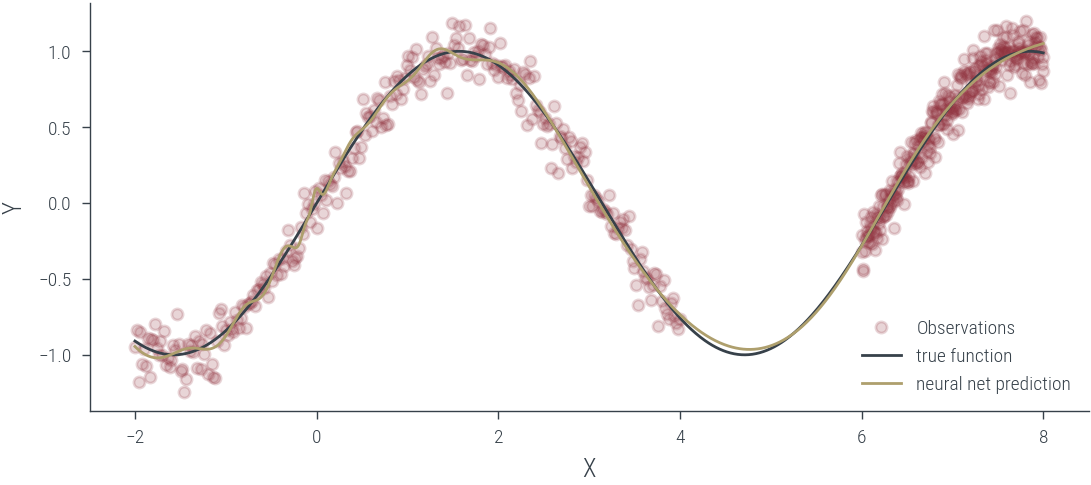

In [40]:
# Plot the trained model
with torch.no_grad():
    y_hat_trained = mlp(test_x, trained_params).ravel()
# Detach and convert to numpy
y_hat_trained = y_hat_trained.cpu().detach().numpy()

plot_predictions(test_x.cpu(), y_hat_trained)

## Deep ensemble with residual connections

In [41]:
n_ensembles = 5

ensemble_params_list = []
for i in range(n_ensembles):
    print(f"Training ensemble member {i}")
    parameters = init_params()
    optimizer = torch.optim.Adam(parameters, lr=3e-4)
    trained_params = train(parameters, optimizer, mlp, train_x, train_y, epochs=6000, dropout=False, p=0.0)
    ensemble_params_list.append(trained_params)

Training ensemble member 0
Epoch 0, loss 135.735


Epoch 300, loss 0.306
Epoch 600, loss 0.067
Epoch 900, loss 0.029
Epoch 1200, loss 0.022
Epoch 1500, loss 0.019
Epoch 1800, loss 0.018
Epoch 2100, loss 0.017
Epoch 2400, loss 0.016
Epoch 2700, loss 0.015
Epoch 3000, loss 0.015
Epoch 3300, loss 0.014
Epoch 3600, loss 0.014
Epoch 3900, loss 0.014
Epoch 4200, loss 0.013
Epoch 4500, loss 0.013
Epoch 4800, loss 0.013
Epoch 5100, loss 0.012
Epoch 5400, loss 0.012
Epoch 5700, loss 0.012
Training ensemble member 1
Epoch 0, loss 8.956
Epoch 300, loss 0.085
Epoch 600, loss 0.041
Epoch 900, loss 0.021
Epoch 1200, loss 0.017
Epoch 1500, loss 0.015
Epoch 1800, loss 0.014
Epoch 2100, loss 0.013
Epoch 2400, loss 0.013
Epoch 2700, loss 0.013
Epoch 3000, loss 0.013
Epoch 3300, loss 0.012
Epoch 3600, loss 0.012
Epoch 3900, loss 0.012
Epoch 4200, loss 0.012
Epoch 4500, loss 0.012
Epoch 4800, loss 0.011
Epoch 5100, loss 0.011
Epoch 5400, loss 0.011
Epoch 5700, loss 0.011
Training ensemble member 2
Epoch 0, loss 13.405
Epoch 300, loss 0.087
Epoch 600, loss

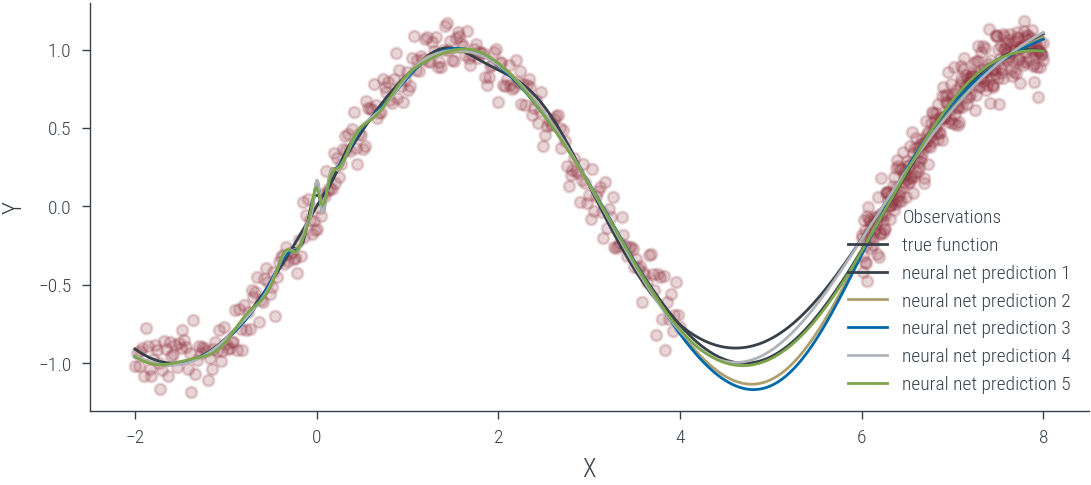

In [42]:
y_preds_list = []
for trained_params in ensemble_params_list:
    with torch.no_grad():
        y_hat_trained = mlp(test_x, trained_params)
        y_hat_trained = y_hat_trained.cpu().numpy()
        y_preds_list.append(y_hat_trained)
        
plot_deep_ensemble(test_x.cpu(), y_preds_list)

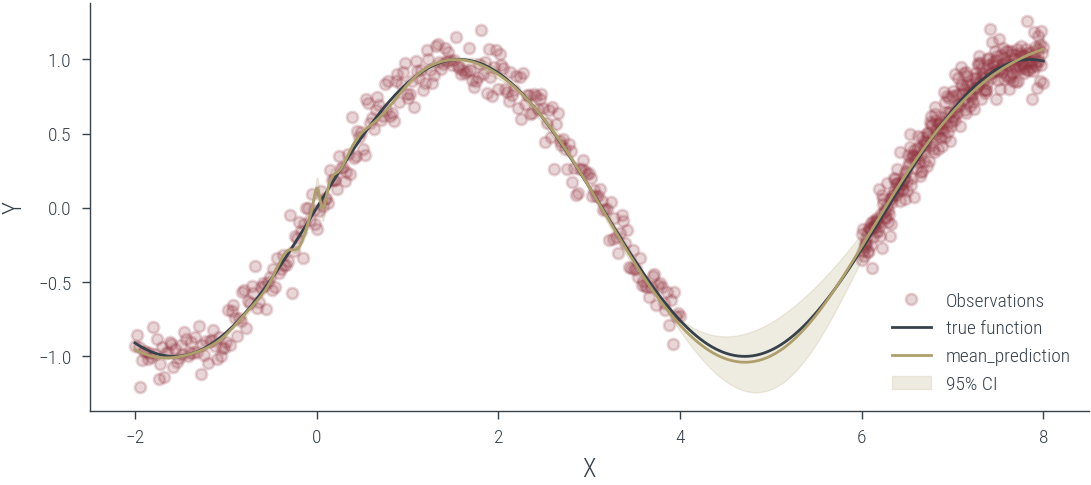

In [43]:
plot_deep_ensemble_uncertainty(test_x.cpu(), y_preds_list)

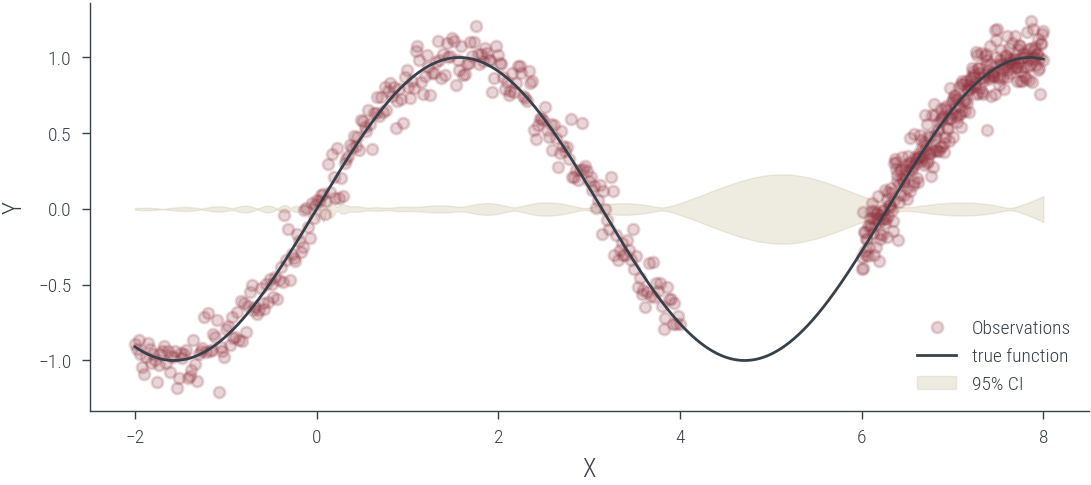

In [44]:
plot_just_uncertainty_deep_ensemble(test_x.cpu(), y_preds_list)

## MC-dropout with residual connections

In [45]:
### Rewriting the model with dropout

input_dim = 1

hidden_l1_dim = 30
hidden_l2_dim = 30

def init_params():
    W1 = nn.Parameter(torch.randn(input_dim, hidden_l1_dim, requires_grad=True).to(device))
    b1 = nn.Parameter(torch.zeros(hidden_l1_dim, requires_grad=True).to(device))
    W2 = nn.Parameter(torch.randn(hidden_l1_dim, hidden_l2_dim, requires_grad=True).to(device))
    b2 = nn.Parameter(torch.zeros(hidden_l2_dim, requires_grad=True).to(device))
    W3 = nn.Parameter(torch.randn(hidden_l2_dim, 1, requires_grad=True).to(device))
    b3 = nn.Parameter(torch.zeros(1, requires_grad=True).to(device))
    return [W1, b1, W2, b2, W3, b3]

def mlp_dropout(x, params, p=0.0, training=True):
    W1, b1, W2, b2, W3, b3 = params
    h1 = torch.tanh(x @ W1 + b1)
    #####################
    # We don't want to apply dropout to the input layer
    #####################
    # if training:
        # probability of dropping out each neuron
        # mask = torch.rand_like(h1) > p
        # h1 = h1 * mask
        # scale activations to account for dropout
        #h1 = h1 / (1 - p)
    h2 = torch.tanh(h1 @ W2 + b2)
    if training:
        # probability of dropping out each neuron
        mask = torch.rand_like(h2) > p
        h2 = h2 * mask
        # scale activations to account for dropout
        h2 = h2 / (1 - p)
    # add residual connection
    h2 = h2 + h1
    h3 = h2 @ W3 + b3
    return h3.ravel()

In [46]:
# Train the model
p = 0.5
parameters = init_params()

# Continue with optimizer
optimizer = torch.optim.Adam(parameters, lr=1e-3)
trained_params = train(parameters, optimizer, mlp_dropout, train_x, train_y, epochs=6000, dropout=True, p=p)

Epoch 0, loss 34.692


Epoch 300, loss 5.850
Epoch 600, loss 1.107
Epoch 900, loss 0.332
Epoch 1200, loss 0.179
Epoch 1500, loss 0.112
Epoch 1800, loss 0.102
Epoch 2100, loss 0.077
Epoch 2400, loss 0.065
Epoch 2700, loss 0.059
Epoch 3000, loss 0.057
Epoch 3300, loss 0.052
Epoch 3600, loss 0.043
Epoch 3900, loss 0.044
Epoch 4200, loss 0.043
Epoch 4500, loss 0.041
Epoch 4800, loss 0.036
Epoch 5100, loss 0.037
Epoch 5400, loss 0.035
Epoch 5700, loss 0.037


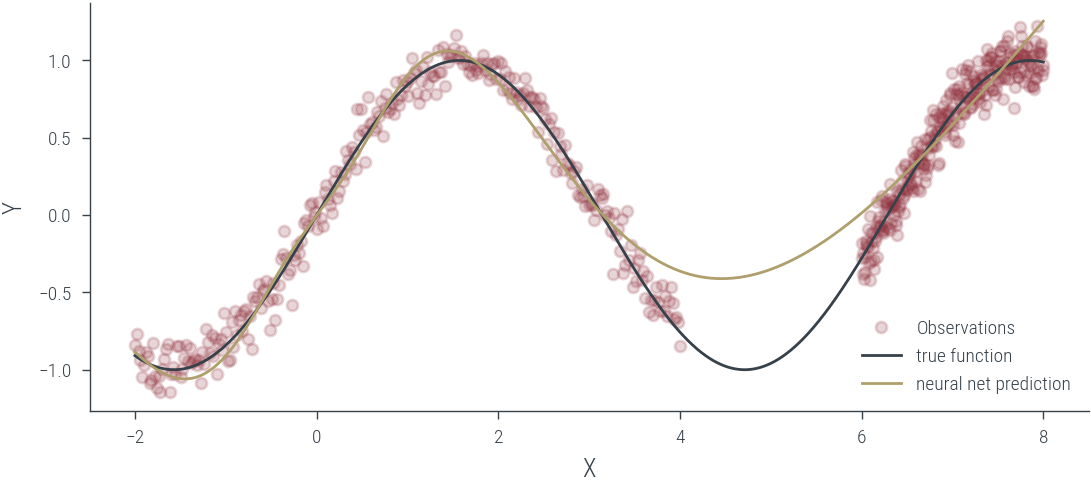

In [47]:
# Predictions with dropout
with torch.no_grad():
    y_hat_dropout = mlp_dropout(test_x, trained_params, training=False).ravel()

# Detach and convert to numpy
y_hat_dropout = y_hat_dropout.cpu().detach().numpy()

plot_predictions(test_x.cpu(), y_hat_dropout)

In [48]:
# Get the predictions for the test set with dropout set to True

preds = []
for i in range(100):
    with torch.no_grad():
        y_hat_dropout = mlp_dropout(test_x, trained_params, training=True, p=p).ravel()
    # Detach and convert to numpy
    y_hat_dropout = y_hat_dropout.cpu().detach().numpy()
    preds.append(y_hat_dropout)

preds = np.array(preds)
preds.shape

(100, 1000)

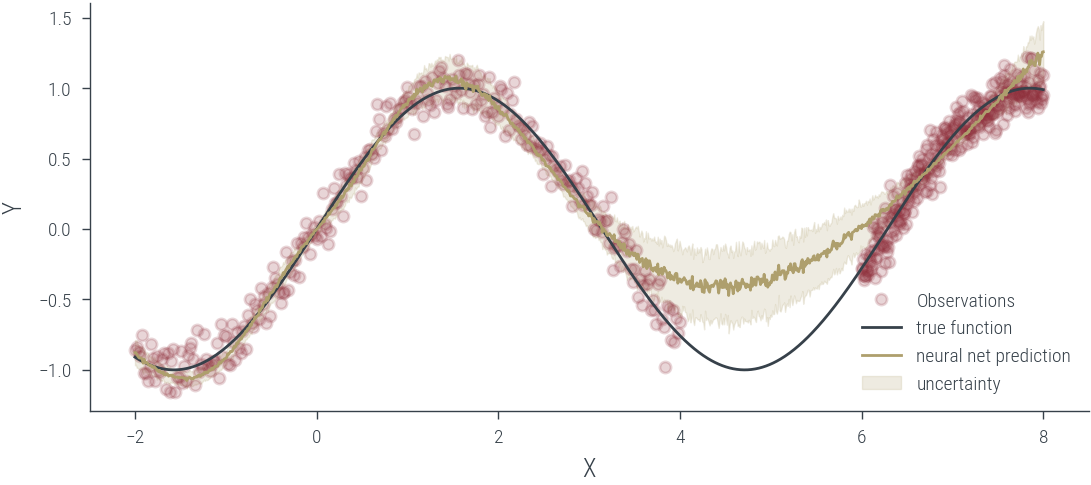

In [49]:
# Plot mean and variance of MC dropout predictions

mean = preds.mean(axis=0)
std = preds.std(axis=0)

def plot_predictions_with_uncertainty(x_test, y_preds, y_std):
    def add_predictions(ax):
        ax.plot(x_test, y_preds, 'C2', label='neural net prediction')
        ax.fill_between(x_test.ravel(), y_preds - y_std, y_preds + y_std, alpha=0.2, color='C2', label='uncertainty')

    plot_generic(add_predictions)

plot_predictions_with_uncertainty(test_x.cpu(), mean, std)

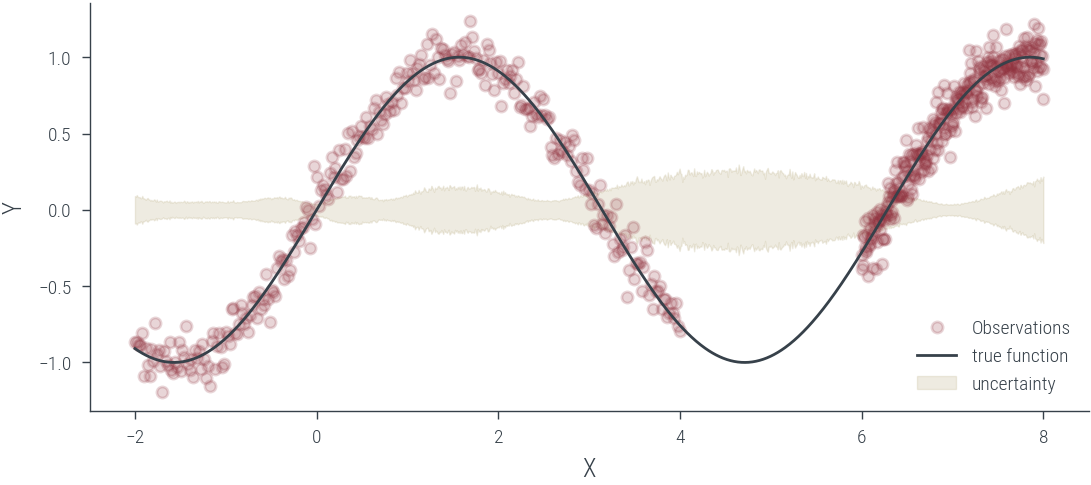

In [50]:
# Just plot the uncertainty

def plot_uncertainty(x_test, y_std):
    def add_predictions(ax):
        ax.fill_between(x_test.ravel(), -y_std, y_std, alpha=0.2, color='C2', label='uncertainty')

    plot_generic(add_predictions)
    
plot_uncertainty(test_x.cpu(), std)